# Übung 2.9 Todesursachen
Wie bereits in anderen Übungen besprochen, muss man zuerst wieder die Daten in das HDFS laden. Dazu habe ich wieder die Datei `death2016.csv` in das Volume des `namenode` Containers hineinkopiert, ich bin in das dazugehörende Verzeichnis in dem `namenode` Container hineingegangen mittels `docker exec -it namenode bash` und `cd /hadoop-data`, und schließlich habe ich die Daten in das HDFS mittels `hadoop fs -copyFromLocal death2016.csv workspace/pyspark` kopiert. 

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql import dataframe
from pyspark.sql.functions import to_timestamp, to_date, year, dayofweek, col
from IPython.display import display

## Einlesen der Datei

In [14]:
# Spark session & context
spark = SparkSession \
    .builder \
    .master('spark://spark-master:7077') \
    .appName("uebung_29") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

In [31]:
# Define schema of death file
death_cols = [
    StructField('country', StringType()),
    StructField('cause_no', IntegerType()),
    StructField('cause_name', StringType()),
    StructField('sex', StringType()),
    StructField('age', IntegerType()),
    StructField('age_group', StringType()),
]

for year in range(2000, 2017):
    death_low_up = [StructField(f'deaths_{year}', FloatType()),
                    StructField(f'low_{year}', FloatType()),
                    StructField(f'up_{year}', FloatType())]
    death_cols += death_low_up
    
death_schema = StructType(death_cols)

In [34]:
# Read in death file
file_path = 'hdfs://namenode:8020/user/root/workspace/pyspark/death2016.csv'
deaths = spark.read.csv(file_path, death_schema)
print(deaths.printSchema())
print(deaths.show(1))

root
 |-- country: string (nullable = true)
 |-- cause_no: integer (nullable = true)
 |-- cause_name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_group: string (nullable = true)
 |-- deaths_2000: float (nullable = true)
 |-- low_2000: float (nullable = true)
 |-- up_2000: float (nullable = true)
 |-- deaths_2001: float (nullable = true)
 |-- low_2001: float (nullable = true)
 |-- up_2001: float (nullable = true)
 |-- deaths_2002: float (nullable = true)
 |-- low_2002: float (nullable = true)
 |-- up_2002: float (nullable = true)
 |-- deaths_2003: float (nullable = true)
 |-- low_2003: float (nullable = true)
 |-- up_2003: float (nullable = true)
 |-- deaths_2004: float (nullable = true)
 |-- low_2004: float (nullable = true)
 |-- up_2004: float (nullable = true)
 |-- deaths_2005: float (nullable = true)
 |-- low_2005: float (nullable = true)
 |-- up_2005: float (nullable = true)
 |-- deaths_2006: float (nullable = true)
 |-- 

In [46]:
# Creating a temporary view so that we can execute HiveQL statements
deaths.createOrReplaceTempView('deaths')

## Teilaufgabe 1
Todesursache mit Anzahl an Todesfällen

In [48]:
death_cols = [f'deaths_{year}' for year in range(2000, 2017)]
death_cols_str = '+'.join(death_cols)
stmt = (f'select cause_name, sum({death_cols_str}) as total '
       'from deaths where country = "DEU" '
        'group by cause_name '
       'order by total desc;')
print('HiveQL statement:', stmt)
death_cause_ger = spark.sql(stmt)
death_cause_ger.show()

HiveQL statement: select cause_name, sum(deaths_2000+deaths_2001+deaths_2002+deaths_2003+deaths_2004+deaths_2005+deaths_2006+deaths_2007+deaths_2008+deaths_2009+deaths_2010+deaths_2011+deaths_2012+deaths_2013+deaths_2014+deaths_2015+deaths_2016) as total from deaths where country = "DEU" group by cause_name order by total desc;
+--------------------+--------------------+
|          cause_name|               total|
+--------------------+--------------------+
|          All Causes|1.4551129185058594E7|
|Noncommunicable d...|1.3325673312011719E7|
|Cardiovascular di...|    6070731.26240921|
| Malignant neoplasms|   3786898.846229553|
|Ischaemic heart d...|   3556194.562406063|
|              Stroke|  1135246.9709677696|
|Other circulatory...|   888717.4789266586|
|Respiratory diseases|   875449.3753051758|
|Trachea; bronchus...|    738239.602329731|
|  Digestive diseases|   737520.3945465088|
|Chronic obstructi...|   711904.0276870728|
|    Ischaemic stroke|   681536.0698115826|
|Communica

## Teilaufgabe 2
Todesursache mit Anzahl Todesfällen im Jahr 2016 absteigend sortiert nach Todesursache.

Ich gehe davon aus, dass wiederum die Anzahl Todesfälle in Deutschland gemeint sind.

In [63]:
deaths.filter(deaths['country'] == 'DEU') \
    .filter(deaths['deaths_2016'] > 0) \
    .select('cause_name', 'deaths_2016') \
    .groupBy('cause_name') \
    .sum('deaths_2016') \
    .withColumnRenamed('sum(deaths_2016)', 'deaths_2016') \
    .orderBy('deaths_2016', ascending=False) \
    .show()

+--------------------+------------------+
|          cause_name|       deaths_2016|
+--------------------+------------------+
|          All Causes| 920556.6735839844|
|Noncommunicable d...| 839535.8052215576|
|Cardiovascular di...|343530.82811903954|
| Malignant neoplasms|235379.45161151886|
|Ischaemic heart d...|  191912.831159126|
|Neurological cond...| 72568.20000190288|
|Other circulatory...| 59006.17331010103|
|Respiratory diseases|58838.875165462494|
|              Stroke|58306.235140547156|
|Alzheimer disease...| 48769.67004454136|
|Chronic obstructi...|48208.593697309494|
|Trachea; bronchus...|47131.487330913544|
|Communicable; mat...| 44314.14274406433|
|  Digestive diseases| 40566.07289594412|
|            Injuries| 36706.71230316162|
|    Ischaemic stroke| 35402.90802706033|
|Genitourinary dis...|29864.502741485834|
|Colon and rectum ...|28808.684104919434|
|Unintentional inj...|24941.597425460815|
|   Diabetes mellitus|24763.661523155868|
+--------------------+------------

## Teilaufgabe 3
Erstellen Sie folgende Grafik bezogen auf die Todesursache 0 (Gesamtfälle) (Die Grafik bezieht sich auf Deutschland).

TODO: Erklärungen in allen Teilaufgaben hinzufügen und erklären, dass 'deahts' die Spalten mit den tatsächlichen Todesfällen sind

In [127]:
# Function that extracts the year from the colum name
def extract_year(col_name):
    year = ''
    for char in col_name:
        if char.isdigit():
            year += char
    return year

In [128]:
extract_year('sum(up_2016)')

'2016'

In [129]:
# Function that returns a dataframe with one row and one column per year
def get_death_df(deaths, death_type):
    # Validate parameters
    if death_type not in ['up', 'low', 'deaths']:
        raise ValueError('death_type must be one of "up", "low", or "death"')
    
    # Filter for the relevant rows
    deaths_de_0 = deaths.filter(deaths['country'] == 'DEU') \
        .filter(deaths['cause_no'] == 0)

    # Create a dataframe with one row where the first column is cause_no and all the other columns
    # contain the death data for each year
    cols = [col for col in deaths.columns if f'{death_type}_' in col]
    deaths_de_0 = deaths_de_0.groupBy('cause_no').sum(*cols).drop('cause_no', *cols)
    assert deaths_de_0.count() == 1
    deaths_df = deaths_de_0.toPandas()
    print('death_type:', death_type)
    display(deaths_df.head())
    
    # Rename all columns
    for col in deaths_df.columns:
        year = extract_year(col)
        if year:
            deaths_df = deaths_df.rename(columns={col: year})
    
    return deaths_df

death_type: up


,sum(up_2000),sum(up_2001),sum(up_2002),sum(up_2003),sum(up_2004),sum(up_2005),sum(up_2006),sum(up_2007),sum(up_2008),sum(up_2009),sum(up_2010),sum(up_2011),sum(up_2012),sum(up_2013),sum(up_2014),sum(up_2015),sum(up_2016)
0,843813.866302,833598.14032,846751.093079,858939.595093,823146.416809,835246.873291,826624.910645,832002.4021,849529.402679,859621.054047,863828.828613,857820.393341,875914.61615,900959.268066,875921.288635,933929.358765,928803.817902


death_type: deaths


,sum(deaths_2000),sum(deaths_2001),sum(deaths_2002),sum(deaths_2003),sum(deaths_2004),sum(deaths_2005),sum(deaths_2006),sum(deaths_2007),sum(deaths_2008),sum(deaths_2009),sum(deaths_2010),sum(deaths_2011),sum(deaths_2012),sum(deaths_2013),sum(deaths_2014),sum(deaths_2015),sum(deaths_2016)
0,838848.592865,828558.538605,841765.283539,853992.677307,818314.885925,830357.249451,821844.718262,827206.096863,844688.994873,854816.832825,859005.383911,852524.178467,870017.796112,894285.81311,868734.533615,925610.80069,920556.673584


death_type: low


,sum(low_2000),sum(low_2001),sum(low_2002),sum(low_2003),sum(low_2004),sum(low_2005),sum(low_2006),sum(low_2007),sum(low_2008),sum(low_2009),sum(low_2010),sum(low_2011),sum(low_2012),sum(low_2013),sum(low_2014),sum(low_2015),sum(low_2016)
0,833825.616425,823622.689972,836808.017761,849016.656952,813491.437683,825499.812469,817042.248047,822419.843994,839881.529602,849938.210785,854148.235901,847215.332611,864075.717316,887644.153168,861489.567764,917286.926376,912305.019073


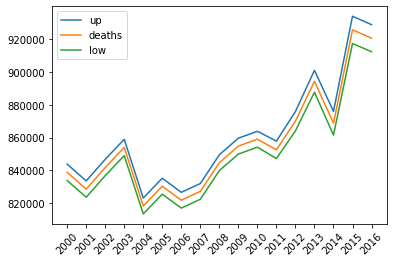

In [132]:
# Plot the upper estimated, actual and lower estimated deaths in one single plot
fig, ax = plt.subplots()
for death_type in ['up', 'deaths', 'low']:
    death_df = get_death_df(deaths, death_type)
    ax.plot(death_df.columns, death_df.values.ravel(), label=death_type)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [4]:
# NEVER FORGET to stop the session
spark.stop()